In [1]:
import imageio
import numpy as np
import porespy as ps
import openpnm as op
import scipy.ndimage as spim
import matplotlib.pyplot as plt
from porespy.filters import find_peaks, trim_saddle_points, trim_nearby_peaks
from porespy.tools import randomize_colors
from skimage.morphology import watershed
ps.visualization.set_mpl_style()

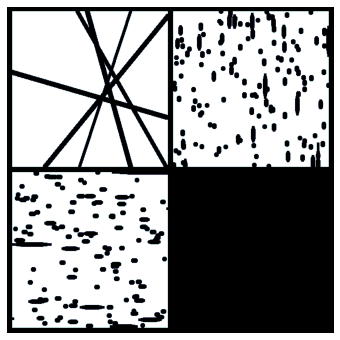

In [2]:


#NBVAL_IGNORE_OUTPUT
np.random.seed(10)
im = ps.generators.cylinders(shape=[300, 300, 300], radius=5, ncylinders=200)
plt.figure(figsize=(6, 6))
plt.imshow(ps.visualization.show_planes(im), cmap=plt.cm.bone)
plt.axis('off')
plt.show()



In [3]:
sigma = 0.4
dt = spim.distance_transform_edt(input=im)
dt = spim.gaussian_filter(input=dt, sigma=sigma)
peaks = find_peaks(dt=dt)

In [4]:

#NBVAL_IGNORE_OUTPUT
print('Initial number of peaks: ', spim.label(peaks)[1])
peaks = trim_saddle_points(peaks=peaks, dt=dt, max_iters=500)
print('Peaks after trimming saddle points: ', spim.label(peaks)[1])
peaks = trim_nearby_peaks(peaks=peaks, dt=dt)
peaks, N = spim.label(peaks)
print('Peaks after trimming nearby peaks: ', N)


Initial number of peaks:  1036
Peaks after trimming saddle points:  788
Peaks after trimming nearby peaks:  701


In [5]:
#NBVAL_IGNORE_OUTPUT
# Ignoring the output of this cell should not be necessary...
# I'm guessing there are deprecation warnings being issued?
regions = watershed(image=-dt, markers=peaks, mask=dt > 0)
regions = randomize_colors(regions)

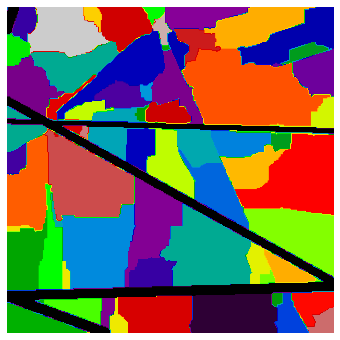

In [6]:

#NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(6, 6))
plt.imshow((regions*im)[:, :, 100], cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.show()


In [7]:


#NBVAL_IGNORE_OUTPUT
net = ps.networks.regions_to_network(im=regions*im, dt=dt, voxel_size=1)



  0%|          | 0/701 [00:00<?, ?it/s]

____________________________________________________________
Extracting pore and throat information from image


100%|██████████| 701/701 [00:14<00:00, 47.30it/s]


In [8]:
pn = op.network.GenericNetwork()
pn.update(net)
prj = pn.project
prj.export_data(filename='extracted_network', filetype='vtk')

In [9]:
#NBVAL_IGNORE_OUTPUT
im = ps.tools.align_image_with_openpnm(im).astype(int)
ps.io.to_vtk(im, path='.extracted_network')